In [1]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen' # ete3 has some interactive part, but we don't have acces to them here

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load libraries

%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

#load my scripts
from utils.mag_scripts import * 
from utils.barplots import * 

import ete3



How does high-fat diet impact the microbiome of mice?
=====================================================

![Picture of obese mice](https://upload.wikimedia.org/wikipedia/commons/0/0b/Fatmouse.jpg)

In [3]:
# Define filepaths

atlas_wd_folder = "../Example/"

taxonomy_file = os.path.join(atlas_wd_folder,"genomes/taxonomy/gtdb_taxonomy.tsv")
tree_file = os.path.join(atlas_wd_folder,"genomes/tree/gtdbtk.bac120.nwk")
quality_file= os.path.join(atlas_wd_folder,"genomes/checkm/completeness.tsv")
counts_file= os.path.join(atlas_wd_folder,"genomes/counts/raw_counts_genomes.tsv")
abundance_file = os.path.join(atlas_wd_folder,"genomes/counts/median_coverage_genomes.tsv")
readstats_file= os.path.join(atlas_wd_folder,"stats/read_counts.tsv")
keggmodules_file = os.path.join(atlas_wd_folder,"genomes/annotations/dram/kegg_modules.tsv")


In [4]:
# load metadata
metadata= pd.read_table('../Example/metadata.txt',index_col=0)
metadata.head()

,Age,Air_temperature,Diet,Food_name,Country,Provider,Sex,Strain,Body_weight
ERR675519,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,30.15
ERR675520,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.61
ERR675521,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,28.29
ERR675522,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.49
ERR675523,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,31.42


We confirm that the mice on high-fat diet put really more weight on.

<AxesSubplot:xlabel='Diet', ylabel='Body_weight'>

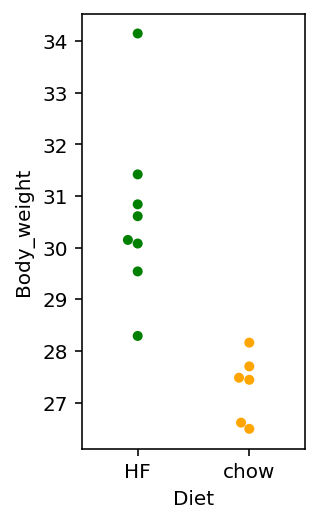

In [5]:
f= plt.figure(figsize=(2,4))
sns.swarmplot(y='Body_weight',x='Diet',data=metadata,palette= ['green','orange'])

In [6]:
# Load taxonomy and create a short label for each genome
Tax= pd.read_table(taxonomy_file,index_col=0)
Labels=Tax.ffill(axis=1).species.copy()
Labels.loc[Tax.species.isnull()]+= ' '+ Labels.index[Tax.species.isnull()]


## Relative abundance


For the relative abundance, we take the coverage over the genome, not the raw counts. This implicitly normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.

In [7]:
D = pd.read_table(abundance_file,index_col=0)
#calculate relative abundance

relab = (D.T/D.sum(1)).T

### Bar chart wich group labels

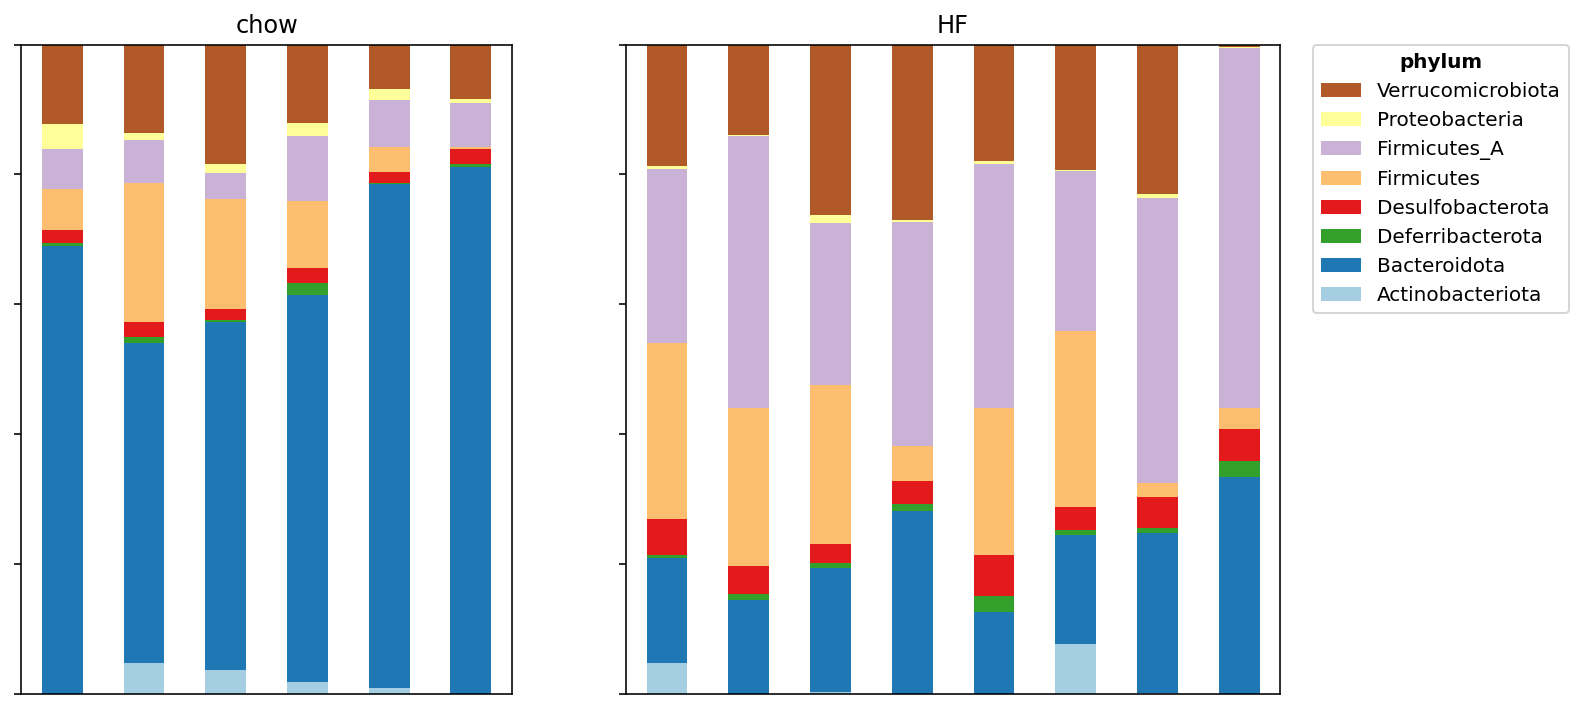

In [8]:

level='phylum'

grouped_data =  relab.groupby(Tax[level],axis=1).sum()*100
filtered_data = filter_taxa( grouped_data,  topN=10)

axe=Grouped_Bar_Plot(filtered_data,metadata.Diet,figsize=(11,5),order=['chow','HF'])

axe[1].legend_.set_title(level,{'weight':'bold'})


## Compositional data analysis 


In order to analyze the microbiome at the species or genome-level we use compositional data analysis (CoDa), see more on [Wikipedia](https://en.wikipedia.org/wiki/Compositional_data) and this article:

>Gloor, Gregory B., Jean M. Macklaim, Vera Pawlowsky-Glahn, and Juan J. Egozcue. 2017. “Microbiome Datasets Are  Compositional: And This Is Not Optional.” Frontiers in Microbiology 8 (November). Frontiers: 2224. 
    doi: [10.3389/fmicb.2017.02224](https://www.frontiersin.org/articles/10.3389/fmicb.2017.02224).

For this, we transform the abundances with the centric log-ratios (CLR) after imputing values for the zeros.

    


In [9]:
# transforme counts with centrig log ratio

data= clr(relab,log=np.log2)

### PCA (PCoA) of the Aitchison distance

In [10]:

from sklearn.decomposition import PCA

pca= PCA()
transformed_data= pca.fit_transform(data)


<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

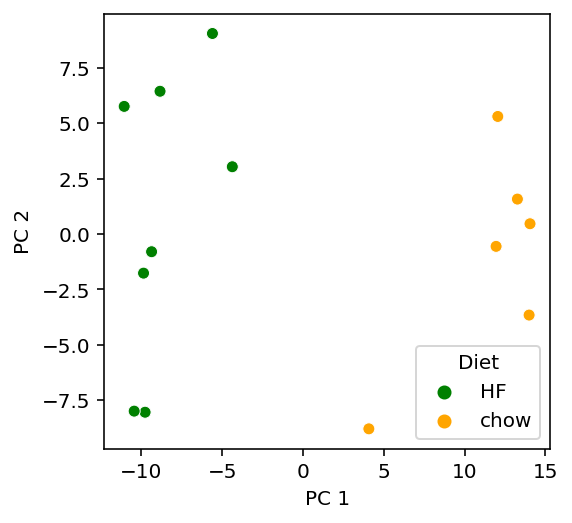

In [11]:
f= plt.figure(figsize=(4,4))
pca_data= pd.DataFrame()
pca_data['PC 1']= transformed_data[:,0]
pca_data['PC 2']= transformed_data[:,1]
pca_data.index= data.index


sns.set_palette(['green','orange'])
sns.scatterplot(x='PC 1',y='PC 2',data=pca_data,hue=metadata.Diet)




### Differencial abundance analyis

Ass the counts are normalized in centered log-ratio the log FC becomes the difference.

We use the welch test to assess differential abundance in the two groups. This is a simple version of aldex2. See Gloor et all for more information.

In [12]:
## Calulate statistics

#man abundance per group
Stats= data.groupby(metadata.Diet).mean().T
Stats['Id']=Stats.index

#log Fold change. is the simple mean difference
Stats['logFC']= Stats.HF-Stats.chow 

# welch test
from scipy.stats import ttest_ind
assert not data.loc[metadata.index].isnull().any().any(),"Found NA values they will interfere with t-test"
_,p= ttest_ind(data.loc[ metadata.query('Diet=="HF"').index ],
          data.loc[ metadata.query('Diet=="chow"').index ],
          equal_var=False
         )

Stats['Pvalue']= p

Stats['Pvalue_BH'] = correct_pvalues_for_multiple_testing(p,correction_type="Benjamini-Hochberg")

Stats['logP']= -np.log10(Stats.Pvalue)
Stats['Name']= Labels


Stats.head()

Diet,HF,chow,Id,logFC,Pvalue,Pvalue_BH,logP,Name
MAG01,1.525037,2.691987,MAG01,-1.166950,0.182184,0.250503,0.739490,Phocaeicola vulgatus
MAG02,0.542791,-4.006490,MAG02,4.549280,0.000002,0.000020,5.739201,Anaerosacchariphilus MAG02
MAG03,-1.690904,0.368315,MAG03,-2.059219,0.198565,0.262106,0.702097,NM07-P-09 sp004793925
MAG04,-0.974163,1.914145,MAG04,-2.888308,0.128418,0.184252,0.891373,Paramuribaculum sp900752995
MAG05,2.606796,-3.240647,MAG05,5.847444,0.000003,0.000023,5.557103,Acetatifactor sp011959105


#### heatmap of significant Genomes



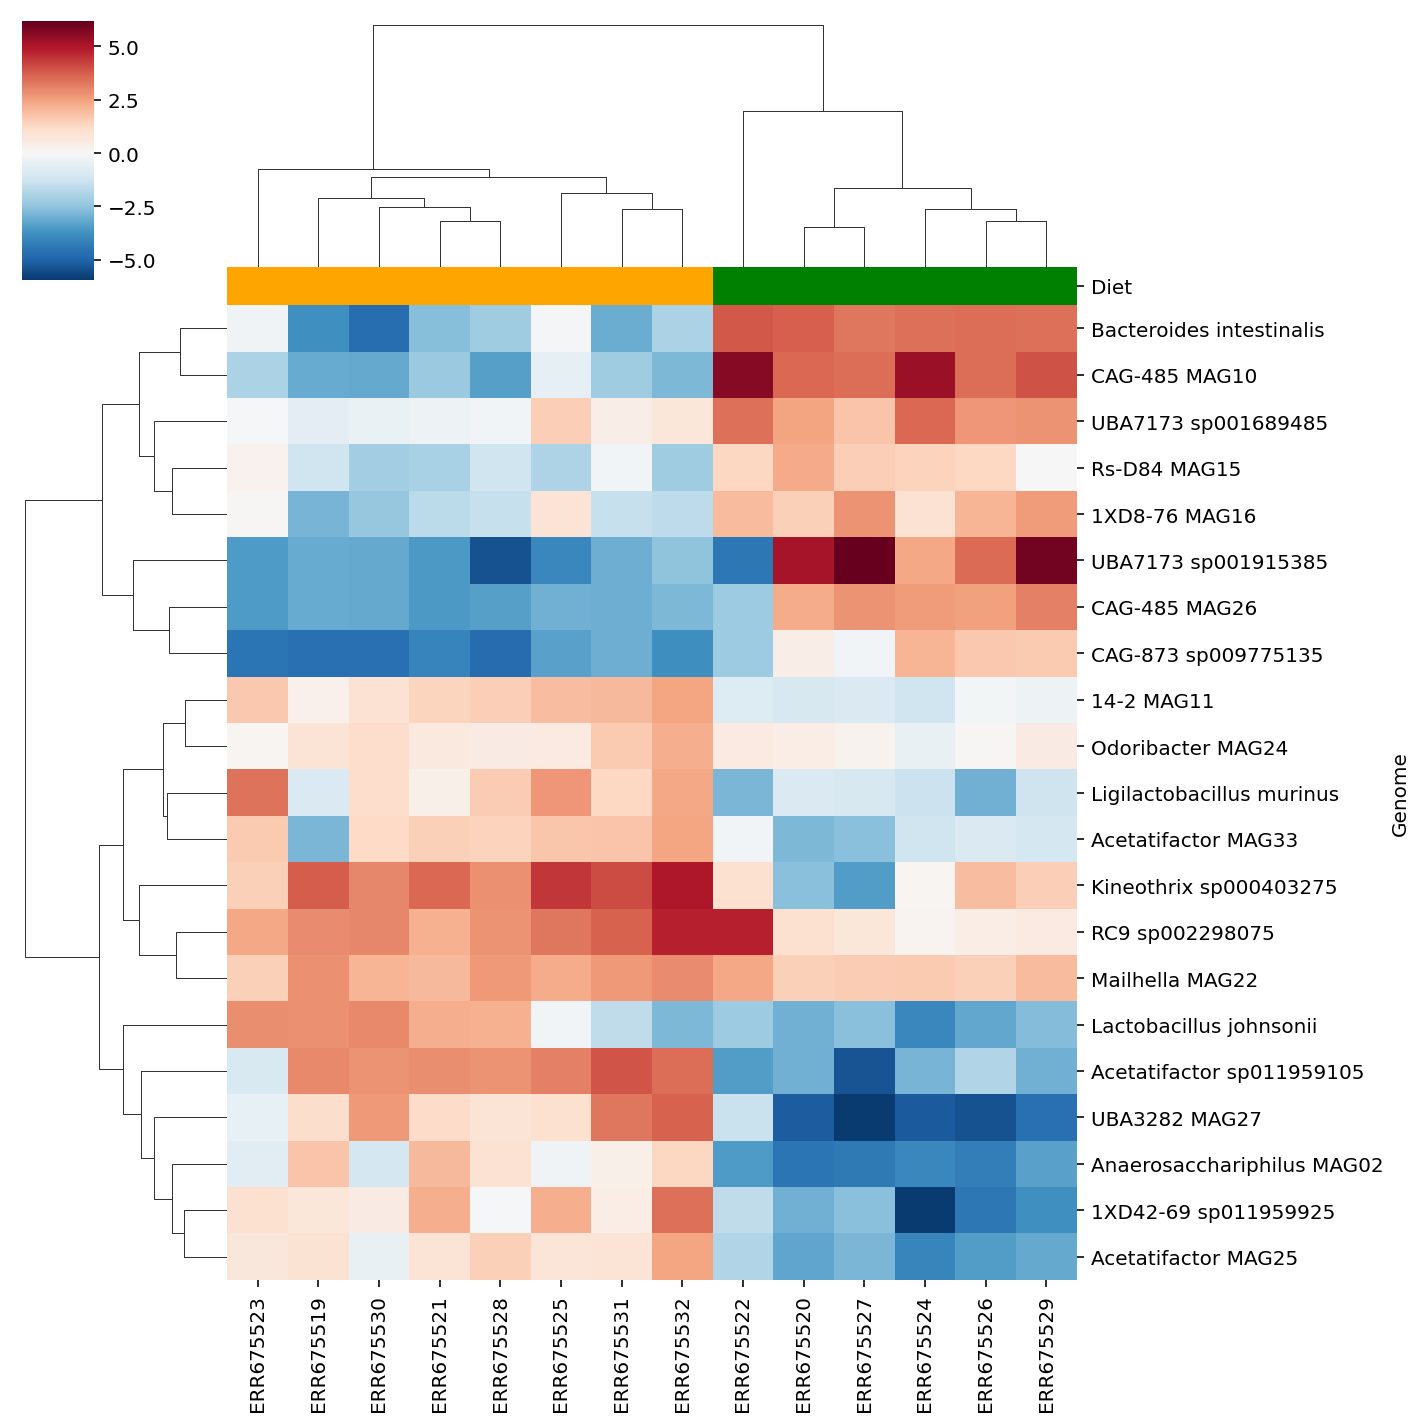

In [13]:
data.columns.name='Genome'
group_color=metadata.Diet.map({'HF':'orange','chow':'green'})

sig_data= data.T.loc[Stats.Pvalue_BH<0.1]

cmp=sns.clustermap(sig_data, center=0, cmap='RdBu_r',
            row_cluster=True,
             yticklabels= Labels.loc[sig_data.index],
               col_colors= group_color,
              );



#### Vulcano plot

In [14]:

#non interactive plot
#sns.scatterplot(y='logP',x='logFC',data=Stats,hue='logP',palette='Reds')


xscale = alt.Scale(type='log')
chart=alt.Chart(Stats).mark_circle(opacity= 0.9).encode(
    y='logP',
    x=alt.X('logFC',title="Lean"+" "*30+"logFC"+" "*30+"Obese"),
    color=alt.Color('logP',scale=alt.Scale(scheme='reds')),
    tooltip=["Name",
        alt.Tooltip( "HF", type = "quantitative",format='.2f'),
        alt.Tooltip( "chow", type = "quantitative",format='.2f'),
             'Id'
    ]
)

chart.interactive()


alt.Chart(...)

Domain                    Bacteria
phylum                  Firmicutes
class                      Bacilli
order              Lactobacillales
family            Lactobacillaceae
genus                Lactobacillus
species    Lactobacillus johnsonii
Name: MAG08, dtype: object

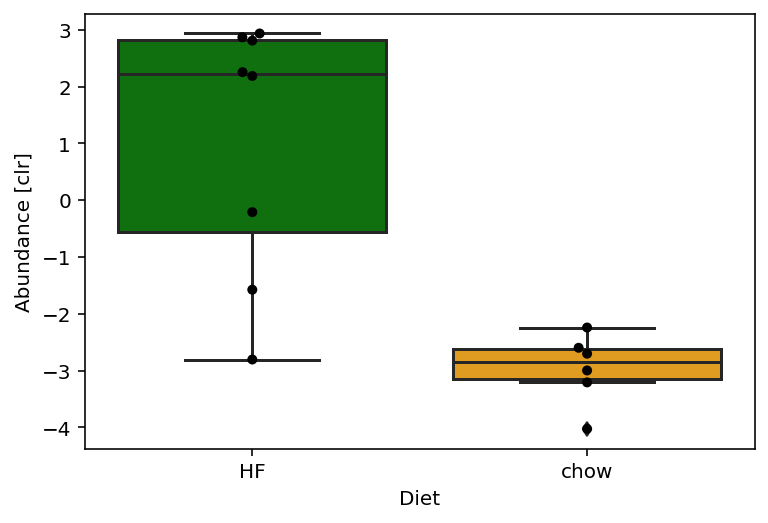

In [15]:

genome_of_interest= 'MAG08'

sns.boxplot(y=data[genome_of_interest],x=metadata.Diet)
sns.swarmplot(y=data[genome_of_interest],x=metadata.Diet,color='k')
plt.ylabel('Abundance [clr]')
Tax.loc[genome_of_interest]

# Functional Differences

In [16]:

# load and calculate module completness
step_coverage_threshold= 0.8

kegg_modules= pd.read_table(keggmodules_file,index_col=[1,2]).drop('Unnamed: 0',axis=1)
module_names =kegg_modules.module_name.droplevel(0).drop_duplicates()



module_step_coverage_matrix = kegg_modules.step_coverage.unstack(fill_value=0)
module_step_coverage_matrix= module_step_coverage_matrix.loc[:, module_step_coverage_matrix.max()>0]
# calcualte presence absence based on threshold
module_presence_matrix = (module_step_coverage_matrix > step_coverage_threshold) *1
#drop all 0 modules
module_presence_matrix= module_presence_matrix.loc[:,module_presence_matrix.max()>0]

# caluclate module relab as sum of all relative abundance where module is present
module_relab = relab @ module_presence_matrix
module_relab.index.name='Sample'

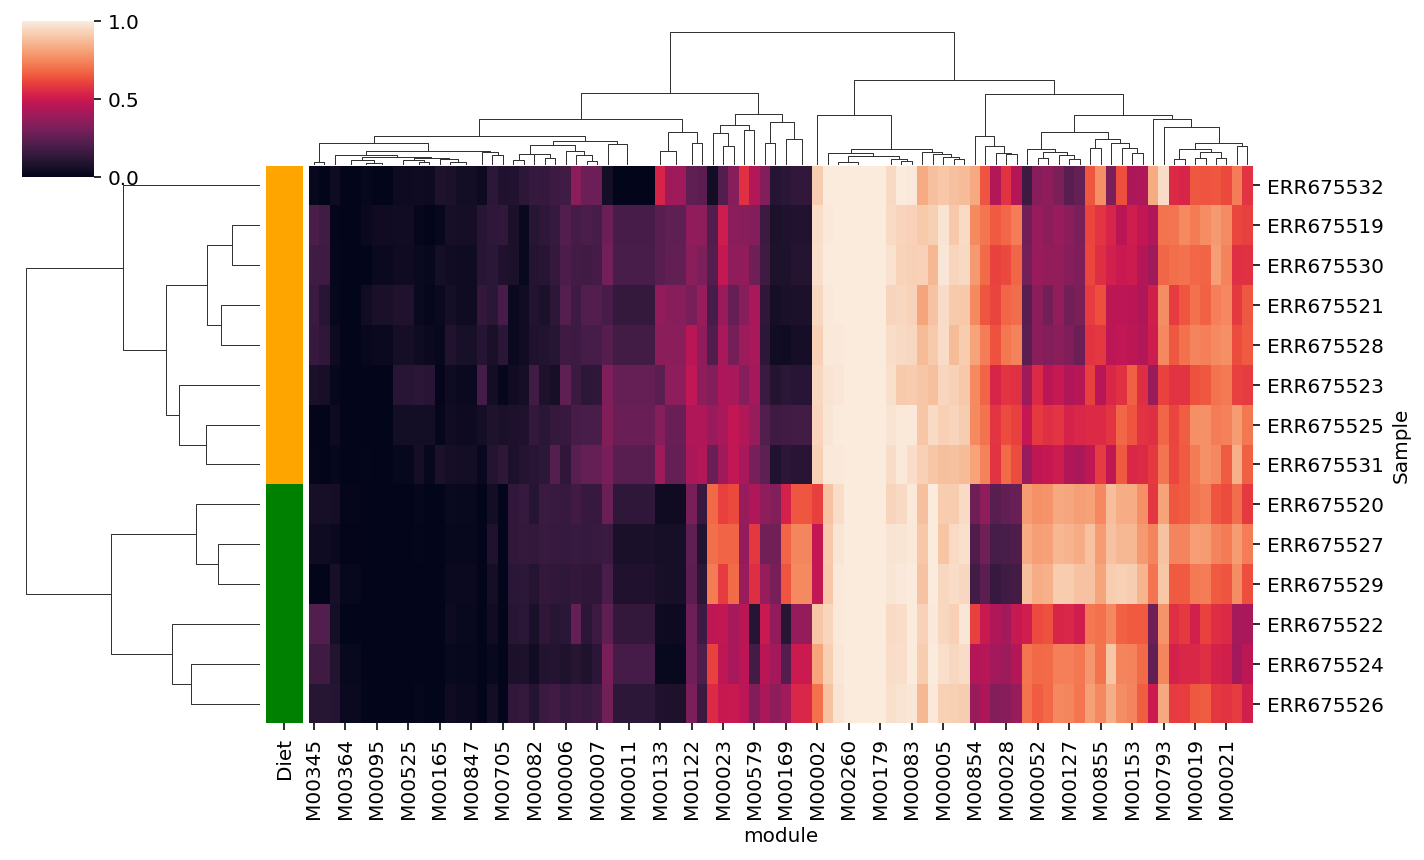

In [17]:
group_colors= metadata.Diet.map({'HF':'orange','chow':'green'}) 

cgi= sns.clustermap(module_relab, figsize=(10,6),row_colors= group_colors)

In [18]:
## Calulate statistics

#man abundance per group
Stats= module_relab.groupby(metadata.Diet).mean().T
Stats['Name']= module_names

Stats['logFC'] = np.log2(Stats.HF / Stats.chow) 

# Manwithney
from scipy.stats import mannwhitneyu

for module in Stats.index:
    _,p= mannwhitneyu(module_relab.loc[metadata.query('Diet=="HF"').index,module],
          module_relab.loc[metadata.query('Diet=="chow"').index,module],
          alternative='two-sided'
         )
    Stats.loc[module,'Pvalue']= p

Stats['Pvalue_BH'] = correct_pvalues_for_multiple_testing( Stats.Pvalue,correction_type="Benjamini-Hochberg")

Stats.query("Pvalue_BH<0.05").sort_values('logFC',ascending=False).head(n=10)


Diet,HF,chow,Name,logFC,Pvalue,Pvalue_BH
module,,,,,,
M00849,0.020216,0.000000,"C5 isoprenoid biosynthesis, mevalonate pathway...",inf,0.012351,0.020337
M00095,0.020216,0.000000,"C5 isoprenoid biosynthesis, mevalonate pathway",inf,0.012351,0.020337
M00705,0.100914,0.001129,"Multidrug resistance, efflux pump MepA",6.481545,0.000666,0.001873
M00165,0.036179,0.000426,Reductive pentose phosphate cycle (Calvin cycle),6.406461,0.000666,0.001873
M00016,0.016491,0.000390,"Lysine biosynthesis, succinyl-DAP pathway, asp...",5.401190,0.000666,0.001873
M00150,0.091728,0.002229,"Fumarate reductase, prokaryotes",5.362572,0.000666,0.001873
M00053,0.054114,0.002174,"Pyrimidine deoxyribonuleotide biosynthesis, CD...",4.637600,0.000666,0.001873
M00525,0.054114,0.002174,"Lysine biosynthesis, acetyl-DAP pathway, aspar...",4.637600,0.000666,0.001873
M00550,0.033898,0.002174,"Ascorbate degradation, ascorbate => D-xylulose-5P",3.962782,0.000666,0.001873


Go to the [Kegg module webpage](https://www.genome.jp/kegg/module.html) and search for an increased module, e.g. M00165 to visualize where it is.

Alse alternative you can go to the [IPath website](https://pathways.embl.de/ipath3.cgi) 



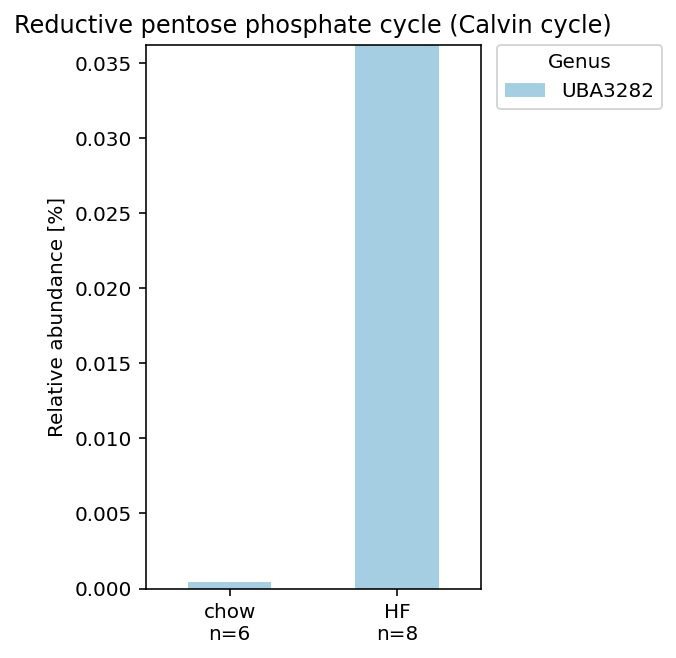

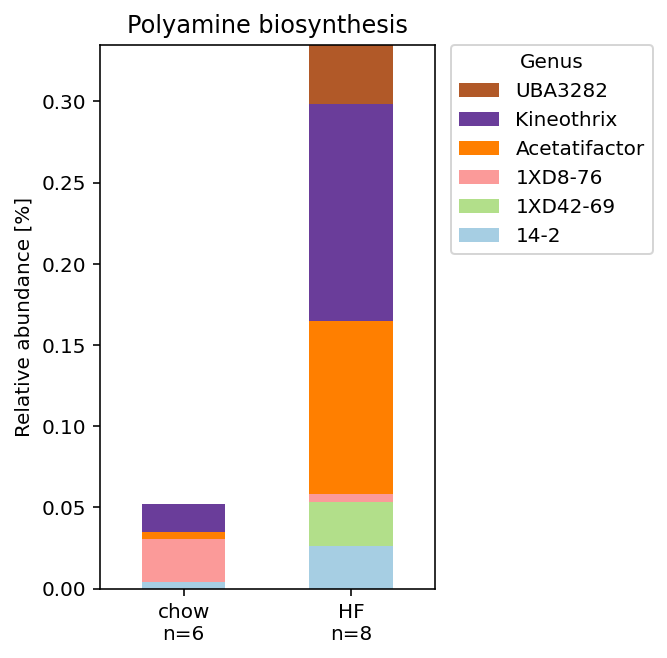

In [19]:
## Show wich species are responsible for the module

taxonomic_level='genus'


for module_of_interest in ['M00165','M00133']:

    genomes_for_module= module_presence_matrix[module_of_interest]==1

    average_abundance= relab.loc[:,genomes_for_module].groupby(Tax[taxonomic_level],axis=1).sum()



    ax=MeanGroup_Barplot(average_abundance,metadata.Diet,topN=10,order=['chow','HF'],figsize=(3, 5))

    ax.set_title(module_names.loc[module_of_interest].split(',')[0],loc='center')
    ax.set_ylabel('Relative abundance [%]')
    ax.legend_.set_title(taxonomic_level[0].upper()+taxonomic_level[1:])

